In [1]:
# dependencies
from dataset import prepare_data, Dataset_train, Dataset_val
from datetime import datetime
from models import DnCNN
from skimage.metrics import peak_signal_noise_ratio
from torch.autograd import Variable
from torch.utils.data import DataLoader
from utils import *
from utils import data_augmentation
from torch import optim 
from torch.utils import data as udata
from  torchvision import utils
from torchvision.datasets import ImageFolder
from torchvision import transforms as tvt
from PIL import Image
from matplotlib import pyplot as plt
import argparse
import cv2
import glob
import h5py
import math
import numpy as np
import os
import os.path
import random
import torch
import torch.nn as nn
device = 'mps' #  for mac, PC users need change to CUDA if they have discrete GPU

In [2]:
# create the model
class DENOISER(nn.Module):
  def __init__(self, layers = 64):
    super(DENOISER, self).__init__()
    chain = []
    K, S, P, F = 3, 1, 1, 16
    activation = nn.ReLU(inplace = True)
    for i in range(layers):
      if not i:
        chain.append(nn.Conv2d(in_channels = 1, out_channels = F, kernel_size = K, stride = S, padding = P))
      elif not i == (layers - 1):
        chain.append(nn.Conv2d(in_channels = F, out_channels = F, kernel_size = K, stride = S, padding = P))
        chain.append(nn.BatchNorm2d(F))
      else:
        chain.append(nn.Conv2d(in_channels = F, out_channels = 1, kernel_size = K, stride = S, padding = P))
      if not i == (layers - 1):
        chain.append(activation)
    self.trans = nn.Sequential(*chain)



  def forward(self, inp):
    return self.trans(inp) - inp

In [3]:
# hyperparameters
net = DENOISER().to(device)
num_epochs =  5
lr = 1e-3
batch_size = 4
opt = optim.Adam(net.parameters(), lr = lr)
criterion = nn.MSELoss(size_average = False)
noiselvl = 45
alpha = 0.5

/Users/ilanbenschikovski/anaconda3/envs/kak/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [4]:
# create toy dataloader
uniform_transform = tvt.Compose([tvt.Grayscale(), tvt.Resize((300, 300)), tvt.ToTensor()])
dataset = ImageFolder(root = 'coco_samples_train', transform = uniform_transform)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [5]:
for epoch in range(1, num_epochs + 1):
  for idx, (data, _), in enumerate(dataloader):
    raw = data.to(device)
    net.train()
    net.zero_grad()
    opt.zero_grad()
    sigma_norm = noiselvl / 255 # max pixel val
    noise = (torch.randn(raw.shape) * sigma_norm).to(device)

    subnoise = raw - noise
    addnoise = raw + noise

    out = net(subnoise)
    loss = criterion(out, addnoise)
    print(loss)
    loss.backward()
    opt.step()
    net.eval()


tensor(255719.1406, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(278939., device='mps:0', grad_fn=<MseLossBackward0>)
tensor(232789.6250, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(225136.5312, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(265076.0625, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(231698.3750, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(110692.0156, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(115392.7656, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(91049.8906, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(106579.5625, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(116629.6250, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(112136.2656, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(86330.4375, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(150910.8750, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(85771.8906, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(74361.2109, device='mps:0', grad_fn=<Mse

In [6]:
# create toy dataloader
uniform_transform = tvt.Compose([tvt.Grayscale(), tvt.Resize((300, 300)), tvt.ToTensor()])
dataset = ImageFolder(root = 'coco_samples_test', transform = uniform_transform)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

torch.Size([4, 1, 300, 300])


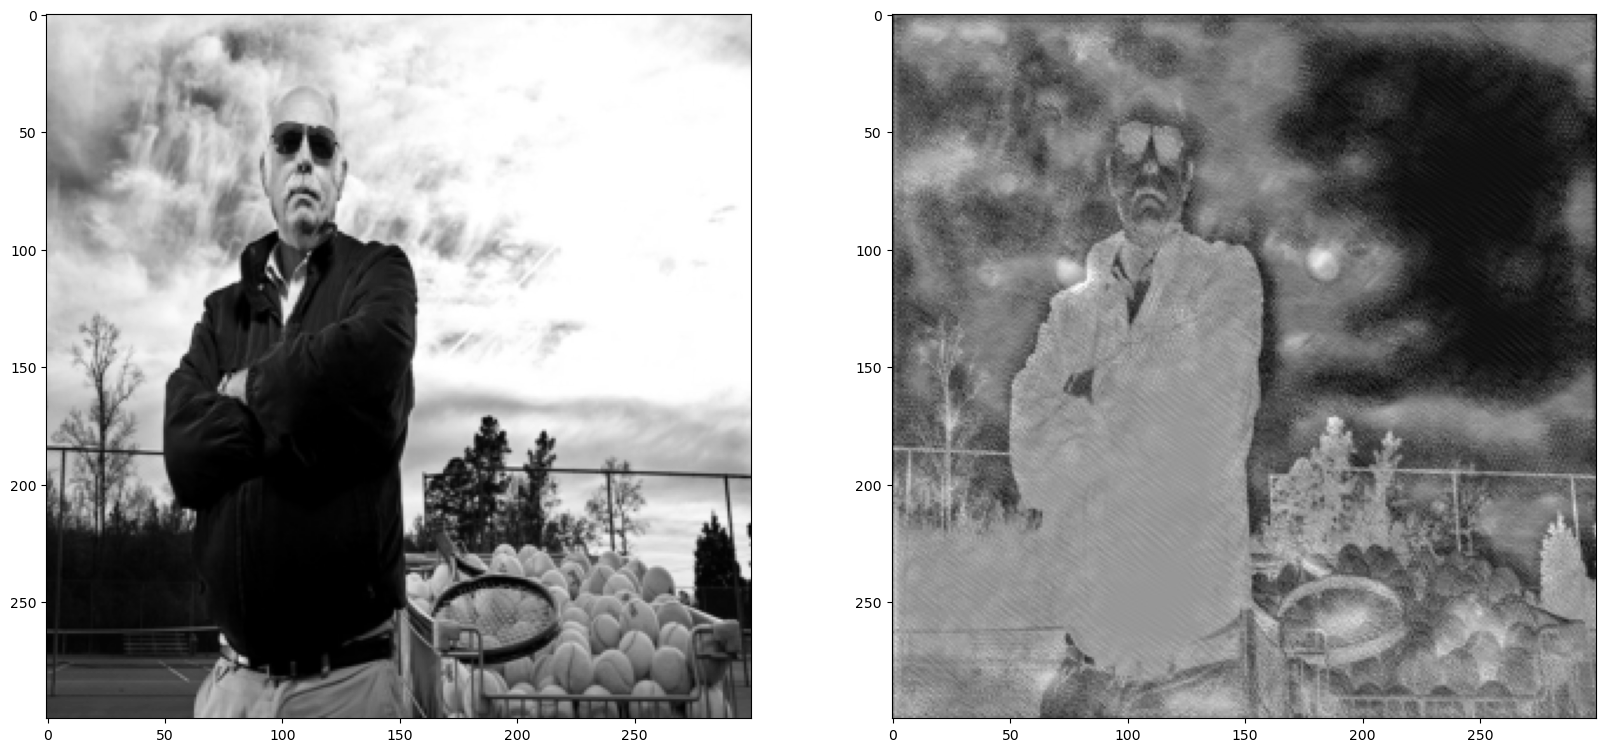

In [7]:
for idx, (data, _), in enumerate(dataloader):
  data = data.to(device)
  out = net(data).to('cpu').detach()
  print(out.shape)
  fig = plt.figure(figsize = (20,50))
  plt.subplot(1,2,1)
  plt.imshow(data.to('cpu')[0].permute(1,2,0), cmap = 'gray')
  plt.subplot(1,2,2)
  plt.imshow(out[0].permute(1,2,0), cmap = 'gray')

  break